In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## 1. Imports and Model Loading

In [1]:
import os
import uuid
import imageio
import numpy as np
from IPython.display import Image as ImageDisplay

from inference import Inference, ready_gaussian_for_video_rendering, load_image, load_masks, display_image, make_scene, render_video, interactive_visualizer

/home/robi/miniconda3/envs/sam3d-objects/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
2026-01-13 22:20:15.512 | INFO     | sam3d_objects.pipeline.inference_pipeline:set_attention_backend:17 - GPU name is NVIDIA RTX PRO 6000 Blackwell Workstation Edition


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2026-01-13 22:20:16.767 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.sparse:__from_env:39 - [SPARSE] Backend: spconv, Attention: sdpa
2026-01-13 22:20:20.031 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.attention:__from_env:30 - [ATTENTION] Using backend: sdpa


[SPARSE][CONV] spconv algo: auto


2026-01-13 22:20:20.946 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2026-01-13 22:20:20.947 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 


In [2]:
PATH = os.getcwd()
TAG = "hf"
config_path = f"{PATH}/../checkpoints/{TAG}/pipeline.yaml"
inference = Inference(config_path, compile=False)

2026-01-13 22:20:21.000 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
/home/robi/miniconda3/envs/sam3d-objects/lib/python3.11/site-packages/moge/model/v1.py:171: UserWarning: The following deprecated/invalid arguments are ignored: {'output_mask': True, 'split_head': True}
  warnings.warn(f"The following deprecated/invalid arguments are ignored: {deprecated_kwargs}")
2026-01-13 22:20:25.529 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2026-01-13 22:20:25.531 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:100 - self.device: cuda
2026-01-13 22:20:25.531 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:101 - CUDA_VISIBLE_DEVICES: None
2026-01-13 22:20:25.532 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:102 - Actually using GPU: 0
2026-01-13 22:20:25.532 | INFO    

## 2. Load input image to lift to 3D (multiple objects)

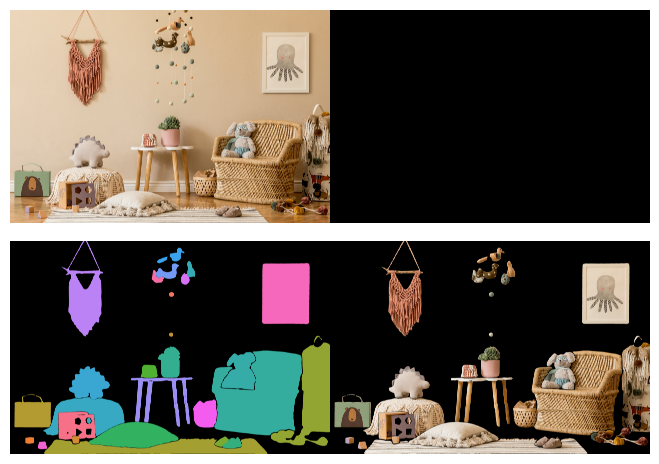

In [7]:
IMAGE_PATH = f"{PATH}/images/shutterstock_stylish_kidsroom_1640806567/image.png"
# IMAGE_PATH = f"/home/robi/projects/sam-3d-objects/data/uniform_sample_10/0.jpg"
IMAGE_NAME = os.path.basename(os.path.dirname(IMAGE_PATH))

image = load_image(IMAGE_PATH)
masks = load_masks(os.path.dirname(IMAGE_PATH), extension=".png")
display_image(image, masks)

## 3. Generate Gaussian Splats

In [8]:
outputs = [inference(image, mask, seed=42) for mask in masks]

2026-01-13 22:23:08.436 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:664 - Sampling sparse structure: inference_steps=25, strength=7, interval=[0, 500], rescale_t=3, cfg_strength_pm=0.0
2026-01-13 22:23:08.437 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:633 - Running condition embedder ...
2026-01-13 22:23:08.536 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:637 - Condition embedder finishes!
2026-01-13 22:23:11.631 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:714 - Downsampled coords from 32440 to 28949
2026-01-13 22:23:11.651 | INFO     | sam3d_objects.pipeline.inference_pipeline_pointmap:run:437 - Rescaling scale by 1 after downsampling
2026-01-13 22:23:11.651 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_slat:744 - Sampling sparse latent: inference_steps=25, strength=1, interval=[0, 500], rescale_t=1
2026-01-13 22:23:11.652 | INFO     | sam

## 4. Visualize Gaussian Splat of the Scene
### a. Animated Gif

In [9]:
scene_gs = make_scene(*outputs)
# export posed gaussian splatting (as point cloud)
scene_gs.save_ply(f"{PATH}/gaussians/{IMAGE_NAME}_posed.ply")

scene_gs = ready_gaussian_for_video_rendering(scene_gs)
# export gaussian splatting (as point cloud)
scene_gs.save_ply(f"{PATH}/gaussians/multi/{IMAGE_NAME}.ply")

video = render_video(
    scene_gs,
    r=1,
    fov=60,
    resolution=512,
)["color"]

# save video as gif
imageio.mimsave(
    os.path.join(f"{PATH}/gaussians/multi/{IMAGE_NAME}.gif"),
    video,
    format="GIF",
    duration=1000 / 30,  # default assuming 30fps from the input MP4
    loop=0,  # 0 means loop indefinitely
)

# notebook display
ImageDisplay(url=f"gaussians/multi/{IMAGE_NAME}.gif?cache_invalidator={uuid.uuid4()}",)

Rendering: 300it [00:28, 10.61it/s]


### b. Interactive Visualizer

In [10]:
# might take a while to load (black screen)
interactive_visualizer(f"{PATH}/gaussians/multi/{IMAGE_NAME}.ply")

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a2bcd0edb2c961fe53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
